In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

2024-05-31 04:31:32.450314: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 04:31:32.450449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 04:31:32.457837: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BASE_DIR = '/kaggle/input/flickr-image-dataset/flickr30k_images'
# /kaggle/input/flickr-image-dataset/flickr30k_images/results.csv
WORKING_DIR = '/kaggle/working'

# Extract Image Features

In [3]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
features = {}
directory = os.path.join(BASE_DIR, 'flickr30k_images')

for img_name in tqdm(os.listdir(directory)):
    try:
        # Load the image from file
        img_path = os.path.join(directory, img_name)
        image = load_img(img_path, target_size=(224, 224))
        # Convert image pixels to numpy array
        image = img_to_array(image)
        # Reshape data for model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # Preprocess image for VGG
        image = preprocess_input(image)
        # Extract features
        feature = model.predict(image, verbose=0)
        # Get image ID
        image_id = img_name.split('.')[0]
        # Store feature
        features[image_id] = feature
    except Exception as e:
        print(f"Error processing {img_name}: {e}")


In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [4]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

# Load Captions

In [5]:
import csv
import os
from tqdm import tqdm

# Define the path to the CSV file
csv_file = os.path.join(BASE_DIR, 'results.csv')

# Create mapping of image to captions
mapping = {}

# Open the CSV file with UTF-8 encoding
with open(csv_file, 'r', encoding='utf-8') as f:
    # Create a CSV reader
    reader = csv.reader(f, delimiter='|')  # Specify the delimiter as '|'
    # Skip the header row
    next(reader)
    # Process each row
    for row in tqdm(reader):
        # Check if the row has at least two elements
        if len(row) < 3:
            continue
        # Extract image ID and caption from the row
        image_id, _, caption = row
        # Remove whitespaces from the fields
        image_id = image_id.strip()
        caption = caption.strip()
        # Remove extension from image ID
        image_id = os.path.splitext(image_id)[0]
        # Create list if needed
        if image_id not in mapping:
            mapping[image_id] = []
        # Store the caption
        mapping[image_id].append(caption)

# Example usage:
# Now you have the mapping of image IDs to captions in the `mapping` dictionary.
# You can use this mapping for further processing or analysis.


158915it [00:00, 253000.08it/s]


In [6]:
len(mapping)

31783

# Preprocessing Text Data

In [7]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [8]:
# before preprocess of text
mapping['1000092795']

['Two young guys with shaggy hair look at their hands while hanging out in the yard .',
 'Two young , White males are outside near many bushes .',
 'Two men in green shirts are standing in a yard .',
 'A man in a blue shirt standing in a garden .',
 'Two friends enjoy time spent together .']

In [9]:
# preprocess the text
clean(mapping)

In [10]:
# after preprocess of text
mapping['1000092795']

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq']

In [11]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [12]:
len(all_captions)

158914

In [13]:
all_captions[:10]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq',
 'startseq several men in hard hats are operating giant pulley system endseq',
 'startseq workers look down from up above on piece of equipment endseq',
 'startseq two men working on machine wearing hard hats endseq',
 'startseq four men on top of tall structure endseq',
 'startseq three men on large rig endseq']

In [14]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [15]:
vocab_size

18313

In [16]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

74

# Train Test Split

In [17]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [18]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

# Model Creation

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, add
from tensorflow.keras.utils import plot_model

# Define the encoder model
# Image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
# Disable cuDNN in LSTM to handle non-right-padded sequences
se3 = LSTM(256, use_cudnn=False)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plot the model
plot_model(model, show_shapes=True)

# Print the model summary
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 74)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image (InputLayer)  │ (None, 4096)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 74, 256)   │  4,688,128 │ text[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4096)      │          0 │ image[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 74, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 74)        │          0 │ text[0][0]        │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,048,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 18313)     │  4,706,441 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,034,505 (42.09 MB)

 Trainable params: 11,034,505 (42.09 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
from keras.callbacks import Callback

epochs = 20
batch_size = 32
steps = len(train) // batch_size

# Check if there is a latest saved model
latest_epoch = 0
model_files = [f for f in os.listdir(WORKING_DIR) if f.startswith('model_epoch_')]
if model_files:
    latest_epoch = max([int(f.split('_')[-1].split('.')[0]) for f in model_files])
    model.load_weights(os.path.join(WORKING_DIR, f'model_epoch_{latest_epoch}.weights.h5'))
    print(f"Loaded model from epoch {latest_epoch}")

# Adjust the number of epochs to run if a model was loaded
epochs -= latest_epoch

# Custom callback to save the model with the correct epoch number
class CustomModelCheckpoint(Callback):
    def __init__(self, save_path, initial_epoch):
        super(CustomModelCheckpoint, self).__init__()
        self.save_path = save_path
        self.epoch = initial_epoch

    def on_epoch_end(self, epoch, logs=None):
        save_filename = self.save_path.format(epoch=self.epoch)
        self.model.save_weights(save_filename)
        print(f"Saved model weights at {save_filename}")
        self.epoch += 1

# Create the custom checkpoint callback
checkpoint_callback = CustomModelCheckpoint(
    save_path=os.path.join(WORKING_DIR, 'model_epoch_{epoch:02d}.weights.h5'),
    initial_epoch=latest_epoch + 1
)

# Train the model
for i in range(latest_epoch, latest_epoch + epochs):
    # Create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # Fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[checkpoint_callback])

Loaded model from epoch 20


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [21]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

KeyboardInterrupt: 

In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [ ]:
from keras.models import load_model

# Load the model
model = load_model(os.path.join(WORKING_DIR, 'best_model.h5'))


# Generate Captions for the Image

In [22]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [23]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [24]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 5/3179 [00:05<1:03:28,  1.20s/it]


KeyboardInterrupt: 

# Visualise the Result

In [25]:
directory = os.path.join(BASE_DIR, 'flickr30k_images')

In [51]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(directory, image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)
    return y_pred

---------------------Actual---------------------
startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq
startseq two young white males are outside near many bushes endseq
startseq two men in green shirts are standing in yard endseq
startseq man in blue shirt standing in garden endseq
startseq two friends enjoy time spent together endseq
--------------------Predicted--------------------
startseq man in blue shirt and jeans is raking leaves endseq


'startseq man in blue shirt and jeans is raking leaves endseq'

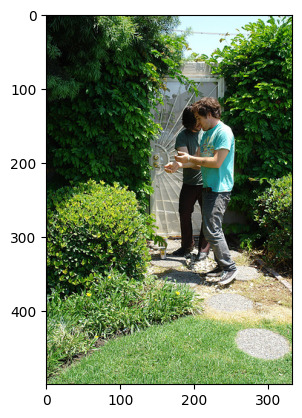

In [52]:
generate_caption("1000092795.jpg")

---------------------Actual---------------------
startseq several men in hard hats are operating giant pulley system endseq
startseq workers look down from up above on piece of equipment endseq
startseq two men working on machine wearing hard hats endseq
startseq four men on top of tall structure endseq
startseq three men on large rig endseq
--------------------Predicted--------------------
startseq two men are working on boat endseq


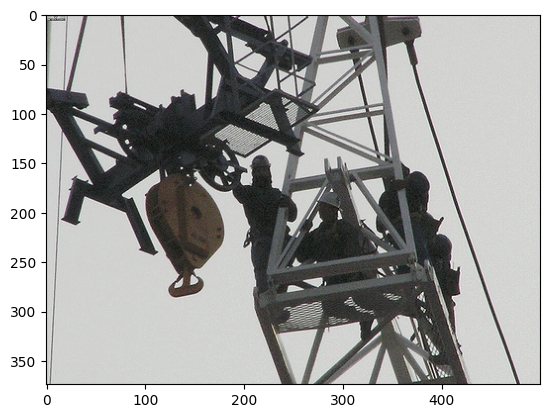

In [28]:
generate_caption("10002456.jpg")

---------------------Actual---------------------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq little girl in pink dress going into wooden cabin endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl climbing into wooden playhouse endseq
startseq girl going into wooden building endseq
--------------------Predicted--------------------
startseq man in blue shirt and jeans is standing in front of an entry way endseq


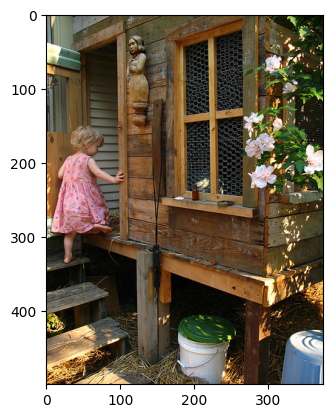

In [29]:
generate_caption("1000268201.jpg")

---------------------Actual---------------------
startseq man with reflective safety clothes and ear protection drives john deere tractor on road endseq
startseq john deere tractors cruises down street while the driver wears easy to see clothing endseq
startseq man in neon green and orange uniform is driving on green tractor endseq
startseq man in tractor wearing headphones driving down paved street endseq
startseq man driving john deere tractor on main road in the country endseq
--------------------Predicted--------------------
startseq man driving tractor endseq


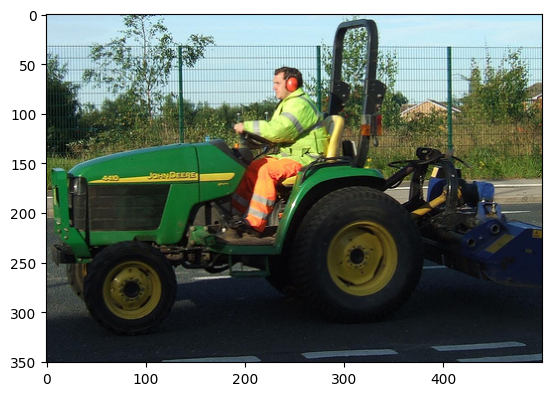

In [30]:
generate_caption("1001896054.jpg")

# Translate Using Google API

In [53]:
!pip install googletrans

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [59]:
def caption_translate(caption,lang='hi'):
    translator = Translator()
    t = translator.translate(caption,lang)
    return t.text

In [72]:
def process_string(input_string):
    if input_string.startswith("startseq "):
        input_string = input_string[len("startseq "):]
    input_string = input_string[0].upper() + input_string[1:]
    input_string = input_string.replace(" endseq", ".", 1)
    print(input_string)
    return input_string

---------------------Actual---------------------
startseq man in red long-sleeved shirt bikes over body of water on bridge endseq
startseq man riding his bike across the bridge that is over the river endseq
startseq man in red on bicycle rides past glass structure endseq
startseq man in red shirt riding his bicycle around water endseq
startseq man in red shirt rides his bicycle endseq
--------------------Predicted--------------------
startseq man in blue shirt is riding bicycle down the street endseq


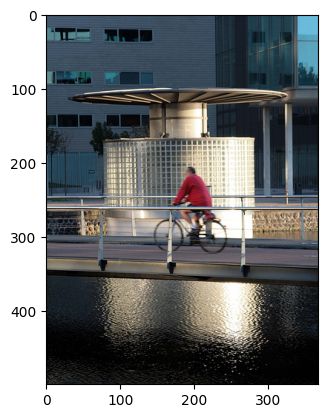

In [82]:
caption1 = generate_caption("1015712668.jpg")

In [83]:
fixed = process_string(caption1)

Man in blue shirt is riding bicycle down the street.


In [84]:
print(caption_translate(fixed,'hi'))
print(caption_translate(fixed,'es'))

ब्लू शर्ट में आदमी सड़क के नीचे साइकिल की सवारी कर रहा है।
Man in Blue Shirt está montando en bicicleta por la calle.


# English Hindi Captions

In [2]:
import os
import string
import numpy as np
import pandas as pd
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
import logging
import tensorflow as tf
# tf.enable_eager_execution()
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
logging.getLogger('tensorflow').setLevel(logging.FATAL)
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import unicodedata
import io
import time
import warnings
import sys


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
PATH = "../input/hindi-english-translate/Hindi_English_Truncated_Corpus.csv"

/kaggle/input/english-to-hindi-translator/__results__.html
/kaggle/input/english-to-hindi-translator/__notebook__.ipynb
/kaggle/input/english-to-hindi-translator/__output__.json
/kaggle/input/english-to-hindi-translator/custom.css
/kaggle/input/english-to-hindi-translator/__results___files/__results___16_0.png
/kaggle/input/english-to-hindi-translator/training_1/cp.ckpt.index
/kaggle/input/english-to-hindi-translator/training_1/cp.ckpt.data-00000-of-00001
/kaggle/input/english-to-hindi-translator/training_1/checkpoint
/kaggle/input/hindi-english-translate/Hindi_English_Truncated_Corpus.csv
/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv
/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/2715746315.jpg
/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/3463034205.jpg
/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/268704620.jpg
/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/2673564214.jpg
/kag

In [3]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.rstrip().strip()
    return w

def hindi_preprocess_sentence(w):
    w = w.rstrip().strip()
    return w

In [4]:
def create_dataset(path=PATH):
    lines=pd.read_csv(path,encoding='utf-8')
    lines=lines.dropna()
    lines = lines[lines['source']=='ted']
    en = []
    hd = []
    for i, j in zip(lines['english_sentence'], lines['hindi_sentence']):
        en_1 = [preprocess_sentence(w) for w in i.split(' ')]
        en_1.append('<end>')
        en_1.insert(0, '<start>')
        hd_1 = [hindi_preprocess_sentence(w) for w in j.split(' ')]
        hd_1.append('<end>')
        hd_1.insert(0, '<start>')
        en.append(en_1)
        hd.append(hd_1)
    return hd, en

In [5]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [6]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
  return tensor, lang_tokenizer

In [7]:
def load_dataset(path=PATH):
    targ_lang, inp_lang = create_dataset(path)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [8]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(PATH)
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [9]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

31904 31904 7977 7977


In [10]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))
    
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
55 ----> who
76 ----> really
660 ----> developed
22883 ----> neurosurgery
32 ----> as
13 ----> we
81 ----> know
156 ----> it ,
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
539 ----> जिन्होंने
1223 ----> आधुनिक
24668 ----> नुरोसुर्जेरी
14 ----> का
248 ----> विकास
70 ----> किया
2 ----> <end>


In [11]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 128
units = 256
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [12]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

In [13]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    hidden_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights

In [14]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    output = tf.reshape(output, (-1, output.shape[2]))
    x = self.fc(output)
    return x, state, attention_weights

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [15]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
#   print(type(mask))
  loss_ *= mask
  return tf.reduce_mean(loss_)

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [17]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0
  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
    # Teacher forcing
    for t in range(1, targ.shape[1]):
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      loss += loss_function(targ[:, t], predictions)
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))      
  return batch_loss

In [18]:
EPOCHS = 20

for epoch in range(EPOCHS):
  start = time.time()
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss
    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

TypeError: in user code:

    File "/tmp/ipykernel_34/3337122791.py", line 5, in train_step  *
        enc_output, enc_hidden = encoder(inp, enc_hidden)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/ipykernel_34/1473581637.py", line 14, in call
        output, state = self.gru(x, initial_state = hidden)

    TypeError: Exception encountered when calling GRU.call().
    
    [1mlen is not well defined for a symbolic Tensor (encoder_1/gru_1/Squeeze:0). Please call `x.shape` rather than `len(x)` for shape information.[0m
    
    Arguments received by GRU.call():
      • sequences=tf.Tensor(shape=(64, 23, 128), dtype=float32)
      • initial_state=tf.Tensor(shape=(64, 256), dtype=float32)
      • mask=None
      • training=False


In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence

In [ ]:
def translate(sentence):
    result, sentence = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
translate(u'politicians do not have permission to do what needs to be done.')